In [1]:
import numpy as np
import os, sys
sys.path.append('../')
from bao_fitter import Data, Model, Fitter
import matplotlib.pyplot as plt

## Data

In [2]:
d = Data(space='fourier', # can be fourier or configuration
         data_file='pk_multipoles.txt', 
         data_file_type='ascii', # a text file in this case, can use npy
         data_file_cols=(0,1,2),
         cov_file='covariance.npy', 
         cov_file_type='npy', # npy but can be ascii
         cov_npoles=2, # number of multipoles in the covariance file
         ell=(0,2), k_min=0.02, k_max=0.2, recon='recsym')

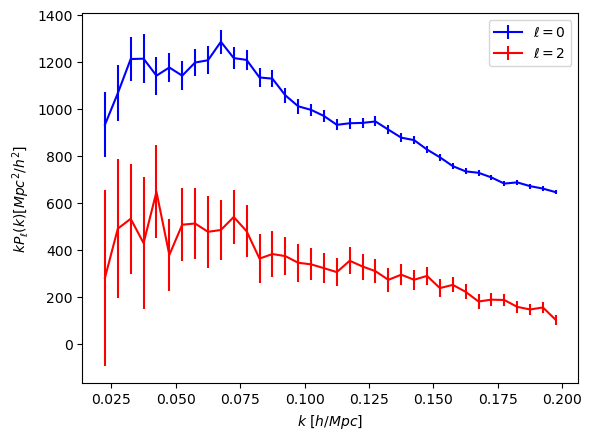

In [3]:
err = np.sqrt(d.cov.diagonal())
n = len(d.k)
colors = ['b', 'r', 'g']
for i, ell in enumerate([0, 2]):
    yerr = err[i*n:(i+1)*n]
    plt.errorbar(d.k, d.k * d.poles[i], yerr=d.k * yerr, color=colors[i], label=f'$\\ell={ell}$')
    plt.legend()
    plt.xlabel(r'$k~[h/Mpc]$')
    plt.ylabel(r'$k P_{\ell}(k) [Mpc^2/h^2]$')

## Model

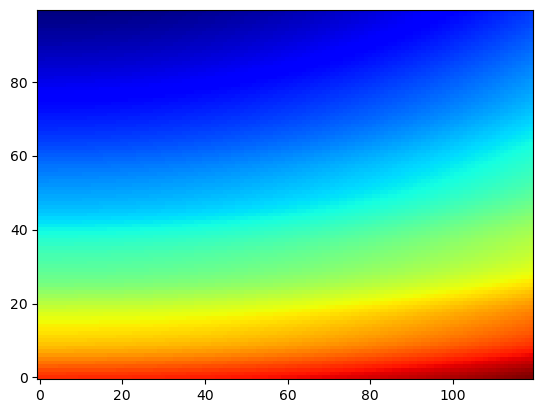

In [4]:
pk_lin = np.loadtxt('linearPk.txt', unpack=True) # Need a 2xN array with k, pklin. You can precompute this with CAMB or CLASS

# The model uses a parameter dictionary
# Parameters don't need to be set when running a fit,
# this is shown as an example
params = {'alpha_par': 1.0,
          'alpha_perp': 0.9,
          'bias': 1.1,
          'beta': 0.3,
          'Sigma_par': 6.,
          'Sigma_perp': 6.,
          'Sigma_s': 0.}


m = Model(pk_linear=pk_lin, params=params)

# You can compute the pk in 2D
k = np.linspace(0.02, 0.3, 100)
mu = np.linspace(0.001, 1, 120)
plt.imshow(np.log(m.power_2D(k, mu)), aspect='auto', cmap='jet', origin='lower')

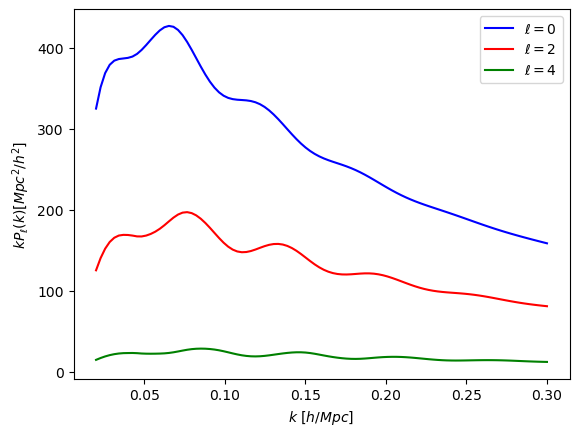

In [5]:
# You can also calculate the multipoles
for i, ell in enumerate([0, 2, 4]):
    plt.plot(k, k * m.pk_poles(k, ell=(ell,)), color=colors[i], label=f'$\\ell={ell}$')
    plt.legend()
    plt.xlabel(r'$k~[h/Mpc]$')
    plt.ylabel(r'$k P_{\ell}(k) [Mpc^2/h^2]$')

## Fitter

In [6]:
fitter = Fitter(data=d,
                model=m,
                bb_exp=(-2, -1, 0, 1, 2), # exponents of the broad-band terms to use
               )         

#### Minimise chi2

In [7]:
min_chi2 = fitter.minimise_chi2() # it uses scipy.optimize internally
# note that the actual values in the model instance get updated automatically

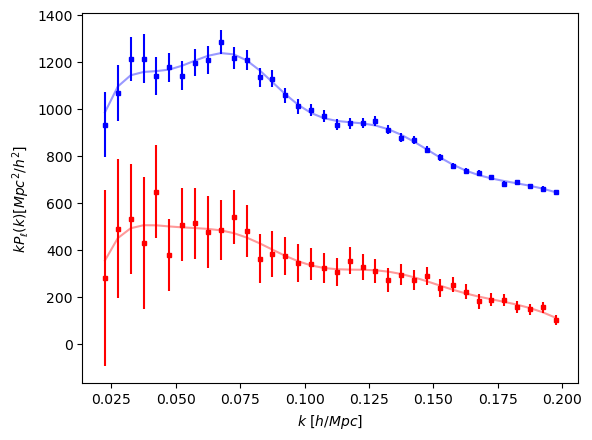

In [8]:
bb, coeff = fitter.broad_band() # returns the broadband terms, to be added to the model
err = np.sqrt(d.cov.diagonal())
n = len(d.k)
colors = ['b', 'r']
for i, ell in enumerate([0, 2]):
    plt.plot(d.k, d.k * (m.pk_poles(d.k, ell=(ell,)) + bb[i]), color=colors[i], alpha=0.4)
    yerr = err[i*n:(i+1)*n]
    plt.errorbar(d.k, d.k * d.poles[i], yerr=d.k * yerr, ls='', marker='s', markersize=3, color=colors[i])
    plt.xlabel(r'$k~[h/Mpc]$')
    plt.ylabel(r'$k P_{\ell}(k) [Mpc^2/h^2]$')

In [9]:
m.params

{'alpha_par': 0.9977923902022267,
 'alpha_perp': 1.0004200696608079,
 'bias': 1.8651742500900788,
 'beta': 0.26930936252321347,
 'Sigma_par': 1.8258794913505116,
 'Sigma_perp': 6.077569723955393,
 'Sigma_s': 1e-08}

#### Run sampler

The following code will be saved as *example.py*.

In [13]:
%%writefile './example.py'
import numpy as np
import os, sys
sys.path.append('../')
from bao_fitter import Data, Model, Fitter
import matplotlib.pyplot as plt

d = Data(space='fourier', # can be fourier or configuration
         data_file='pk_multipoles.txt', 
         data_file_type='ascii', # a text file in this case, can use npy
         data_file_cols=(0,1,2),
         cov_file='covariance.npy', 
         cov_file_type='npy', # npy but can be ascii
         cov_npoles=2, # number of multipoles in the covariance file
         ell=(0,2), k_min=0.02, k_max=0.2, recon='recsym')

pk_lin = np.loadtxt('linearPk.txt', unpack=True)
m = Model(pk_linear=pk_lin)

f = Fitter(data=d,
           model=m,
           bb_exp=(-2, -1, 0, 1, 2), # exponents of the broad-band terms to use
           fixed_params={'Sigma_par':4., 'Sigma_perp':6., 'Sigma_s':0., 'beta':0.3}, # you can specify if you want some of the parameters to be fixed
           )

f.set_sampler_settings(nchains=2,
                       epsilon=0.001, # R-1 for Gelman-Rubin
                       nmin=1000,
                       nmax=2000,
                      )

f.run_sampler(out_path='./')

Overwriting ./example.py


In [11]:
!mpirun -n 2 python example.py

Initial positions: 
Initial positions: 
 [[0.87269611 1.08387308 2.50528101]
 [1.00945337 0.91264274 0.68471287]
 [1.05235972 1.14781856 1.56957159]
 [0.88669653 0.95624829 1.32686593]
 [1.11647193 0.93607923 2.30575485]
 [0.87371051 1.13676753 1.34757082]]
 [[1.08094908 1.12015507 1.10528463]
 [0.91207002 1.03980232 1.1726264 ]
 [0.8968617  1.12693552 1.84473714]
 [1.07740792 0.87961778 2.66143338]
 [1.07111791 0.97201128 1.21304574]
 [0.96839716 1.09124076 1.55920205]]
Initialising ensemble of 6 walkers...
Initialising ensemble of 6 walkers...
Sampling progress :  50%|█████     | 1000/2000 [02:57<02:57,  5.63it/s]R =  [1.000014081610206, 1.002158714519969, 1.0018353587577415, 1.0023002705048463, 1.0010642391952913, 1.0002257164100727, 0.9999452968094763, 1.0006557950259076, 1.0002919324055197, 1.0006451319229968]
Saved file: ./chain_0.npy
Saved file: ./chain_1.npy




**Warning**: If you are running this on NERSC you should do:
```console
srun -n ntasks python example.py
```
However, don't run this from a jupyter notebook. Use an interactive job or create a script for sbatch.

Removed no burn in


<Figure size 600x450 with 0 Axes>

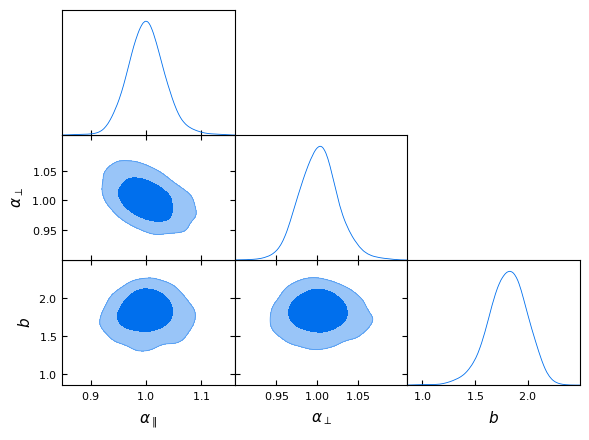

In [14]:
# You can post-process your chains however you want. This example uses getdist
from getdist import plots
from getdist import MCSamples

chain_paths = [f'./chain_{i}.npy' for i in range(2)]
chain_list = []
for path in chain_paths:
    chain = np.load(path)
    nsteps, nwalk, nparms = chain.shape
    chain = np.reshape(chain, (nsteps*nwalk, nparms))
    chain_list.append(chain)
    
g = plots.get_single_plotter()
samples = MCSamples(samples=chain_list, names=[r'$\alpha_{\parallel}$',r'$\alpha_{\perp}$', r'$b$'])
samples.removeBurn(0.3)
g.triangle_plot(samples, filled=True)